# Introduction
* Phan tich cac yeu to anh huong den price tu bang du lieu MELBOURNE_HOUSE
* Yeu cau:
    - 1. Examine and explore data (visualization, interactions among features)
    - 2. Apply the model for prediction with holdout and cross validation
    - 3. Using PCA, apply the model with holdout and cross validation
    - 4. Visualize the residue
    - 5. Tune the model if necessary
    - 6. Write up analysis for each section (for example, explain why the model is overfitting, explain why applying PCA is better, etc.)
    - 7. Include conclusions for summary

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import f_oneway
from yellowbrick.regressor import ResidualsPlot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.decomposition import PCA 
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('D:/machine learning/project/melbourne-housing-market/MELBOURNE_HOUSE_PRICES_LESS.csv')
data.shape

(63023, 13)

# 1. Examine and explore data (visualization, interactions among features)

# 1.1. EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 13 columns):
Suburb           63023 non-null object
Address          63023 non-null object
Rooms            63023 non-null int64
Type             63023 non-null object
Price            48433 non-null float64
Method           63023 non-null object
SellerG          63023 non-null object
Date             63023 non-null object
Postcode         63023 non-null int64
Regionname       63023 non-null object
Propertycount    63023 non-null int64
Distance         63023 non-null float64
CouncilArea      63023 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 6.3+ MB


- Bang du lieu co 63023 dong va 13 cot. Co nhieu cot co the lien quan anh huong den Price nhu Rooms, Address, Suburb,...
- Trong bang chi co Price co nhieu missing value

In [4]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


In [5]:
data.describe(percentiles=[.1,.25,.50,.75,.95,.99])

,Rooms,Price,Postcode,Propertycount,Distance
count,63023.000000,4.843300e+04,63023.000000,63023.000000,63023.000000
mean,3.110595,9.978982e+05,3125.673897,7617.728131,12.684829
std,0.957551,5.934989e+05,125.626877,4424.423167,7.592015
min,1.000000,8.500000e+04,3000.000000,39.000000,0.000000
10%,2.000000,4.800400e+05,3029.000000,2698.000000,4.300000
25%,3.000000,6.200000e+05,3056.000000,4380.000000,7.000000
50%,3.000000,8.300000e+05,3107.000000,6795.000000,11.400000
75%,4.000000,1.220000e+06,3163.000000,10412.000000,16.700000
95%,5.000000,2.100000e+06,3206.000000,15510.000000,26.500000
99%,5.000000,3.200000e+06,3756.000000,21650.000000,38.000000


Tu bang nay ta co the thay co mot so cot co gia tri max bat thuong vi chenh lech rat nhieu so voi cac gia tri khac nhu Rooms, Price

# The target valuable: Distribution of Price

count    4.843300e+04
mean     9.978982e+05
std      5.934989e+05
min      8.500000e+04
10%      4.800400e+05
25%      6.200000e+05
50%      8.300000e+05
75%      1.220000e+06
95%      2.100000e+06
99%      3.200000e+06
max      1.120000e+07
Name: Price, dtype: float64


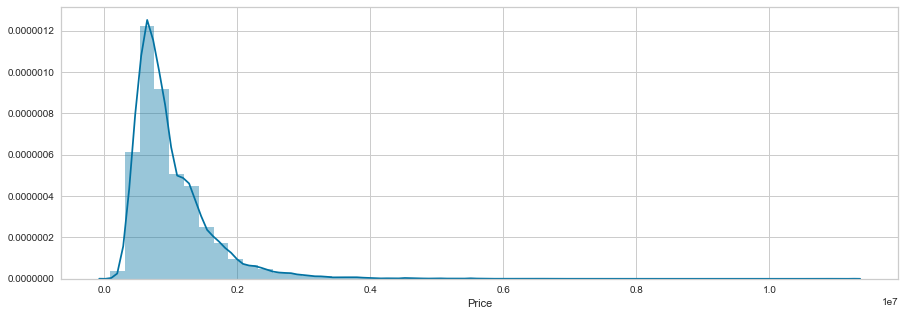

In [6]:
print(data['Price'].describe(percentiles=[.1,.25,.50,.75,.95,.99]))
plt.figure(figsize=(15,5))
sns.distplot(data['Price'])

Nhin tu bieu do thi bien target Price khong phai la phan phoi chuan va co mot so gia tri outliers > 0.4

# Phan loai Numerical and categorical features

In [7]:
num_feature = data.columns[data.dtypes != 'object'].to_list()
category_feature = data.columns[data.dtypes == 'object'].to_list()
print('Number of numerical features: ', len(num_feature))
print(num_feature)
print('Number of categorical features: ', len(category_feature))
print(category_feature)

Number of numerical features:  5
['Rooms', 'Price', 'Postcode', 'Propertycount', 'Distance']
Number of categorical features:  8
['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'Regionname', 'CouncilArea']


In [8]:
#tuy nhien Postcode la categorical feature nen ta dieu chinh lai danh sach phan loai cac feature:
num_feature.pop(2)
print('Number of numerical features: ', len(num_feature))
print(num_feature)
category_feature.append('Postcode')
print('Number of categorical features: ', len(category_feature))
print(category_feature)
num_feature

Number of numerical features:  4
['Rooms', 'Price', 'Propertycount', 'Distance']
Number of categorical features:  9
['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'Regionname', 'CouncilArea', 'Postcode']


['Rooms', 'Price', 'Propertycount', 'Distance']

In [9]:
data[num_feature].head()

,Rooms,Price,Propertycount,Distance
0,3,1490000.0,4019,3.0
1,3,1220000.0,4019,3.0
2,3,1420000.0,4019,3.0
3,3,1515000.0,1543,7.5
4,2,670000.0,3464,10.4


In [10]:
data[num_feature].describe()

,Rooms,Price,Propertycount,Distance
count,63023.000000,4.843300e+04,63023.000000,63023.000000
mean,3.110595,9.978982e+05,7617.728131,12.684829
std,0.957551,5.934989e+05,4424.423167,7.592015
min,1.000000,8.500000e+04,39.000000,0.000000
25%,3.000000,6.200000e+05,4380.000000,7.000000
50%,3.000000,8.300000e+05,6795.000000,11.400000
75%,4.000000,1.220000e+06,10412.000000,16.700000
max,31.000000,1.120000e+07,21650.000000,64.100000


In [11]:
data[category_feature].head()

,Suburb,Address,Type,Method,SellerG,Date,Regionname,CouncilArea,Postcode
0,Abbotsford,49 Lithgow St,h,S,Jellis,1/04/2017,Northern Metropolitan,Yarra City Council,3067
1,Abbotsford,59A Turner St,h,S,Marshall,1/04/2017,Northern Metropolitan,Yarra City Council,3067
2,Abbotsford,119B Yarra St,h,S,Nelson,1/04/2017,Northern Metropolitan,Yarra City Council,3067
3,Aberfeldie,68 Vida St,h,S,Barry,1/04/2017,Western Metropolitan,Moonee Valley City Council,3040
4,Airport West,92 Clydesdale Rd,h,S,Nelson,1/04/2017,Western Metropolitan,Moonee Valley City Council,3042


In [12]:
data[category_feature].describe(include='all')

,Suburb,Address,Type,Method,SellerG,Date,Regionname,CouncilArea,Postcode
count,63023,63023,63023,63023,63023,63023,63023,63023,63023.000000
unique,380,57754,3,9,476,112,8,34,NaN
top,Reservoir,57 Bay Rd,h,S,Barry,24/03/2018,Southern Metropolitan,Boroondara City Council,NaN
freq,1241,7,45053,34063,6894,1144,17559,5132,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3125.673897
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.626877
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3056.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3107.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3163.000000


# Ve bieu do phan phoi cac numerical features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000256E8471EF0>,
      dtype=object)

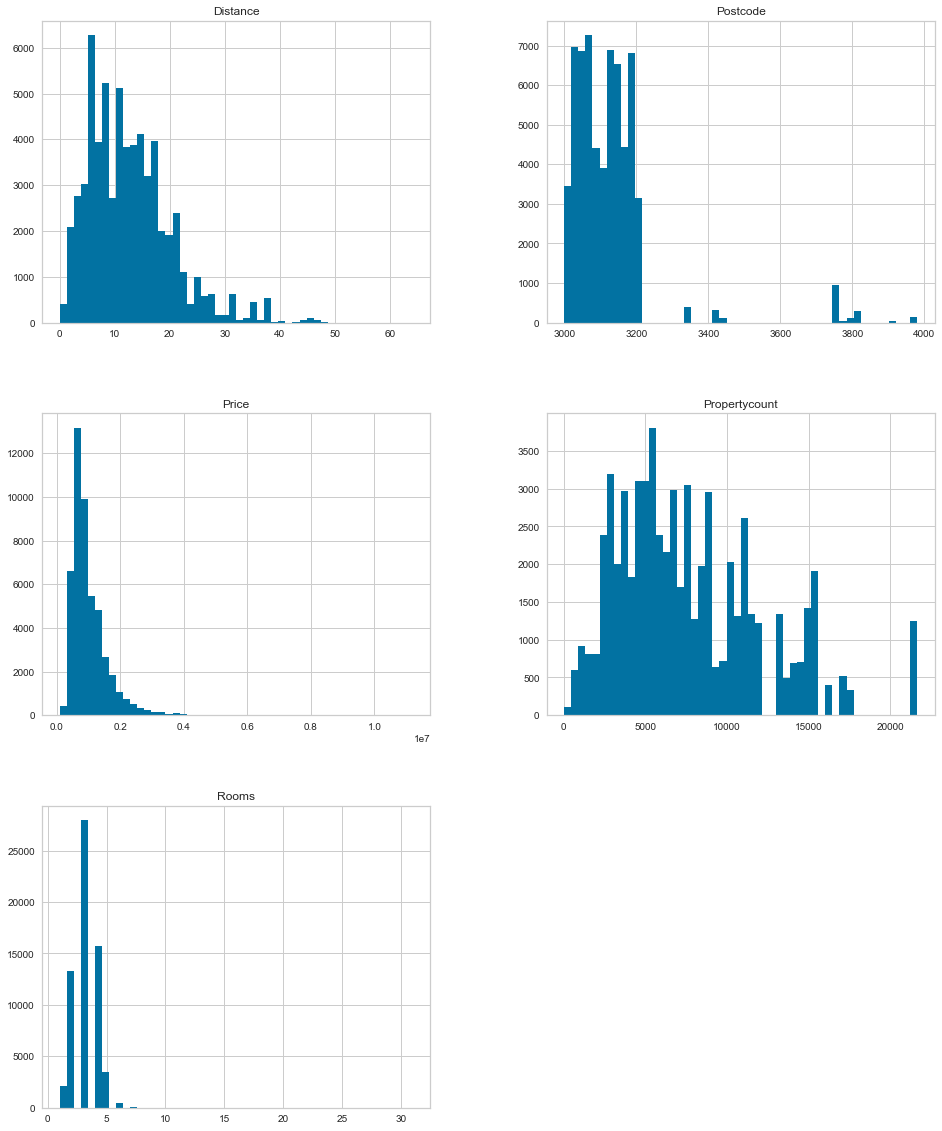

In [13]:
data.hist(figsize=(16, 20), bins=50)

# Kiem tra missing values

In [14]:
data_trans = data
total = data_trans.isnull().sum()
percent = data_trans.isnull().sum()/len(data)*100
missing_data = pd.concat([total,percent], axis=1,keys=['Total', 'Percent'])
missing_data

,Total,Percent
Suburb,0,0.000000
Address,0,0.000000
Rooms,0,0.000000
Type,0,0.000000
Price,14590,23.150278
Method,0,0.000000
SellerG,0,0.000000
Date,0,0.000000
Postcode,0,0.000000
Regionname,0,0.000000


In [15]:
#xoa cac feature co missing value > 30% va lay cac feature con lai
# data_trans = data[[column for column in data if data[column].count()/len(data) > 0.7]]
# total = data_trans.isnull().sum()
# percent = data_trans.isnull().sum()/len(data_trans)*100
# missing_data = pd.concat([total,percent], axis=1,keys=['Total', 'Percent'])
# missing_data

In [16]:
# xoa cac missing value
data_trans = data_trans.dropna()

In [17]:
data_trans.isnull().sum().sum()

0

# Relation of numerical features to target(Price)

In [18]:
num_feature = [c for c in num_feature if c in data_trans.columns]
num_feature

['Rooms', 'Price', 'Propertycount', 'Distance']

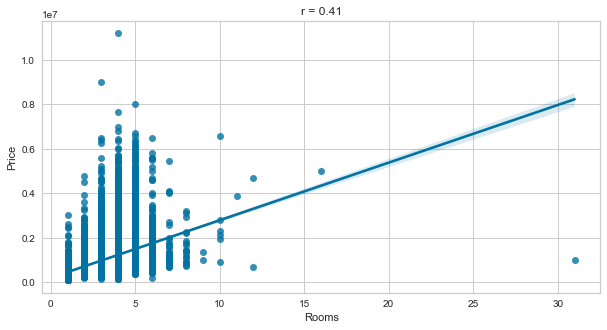

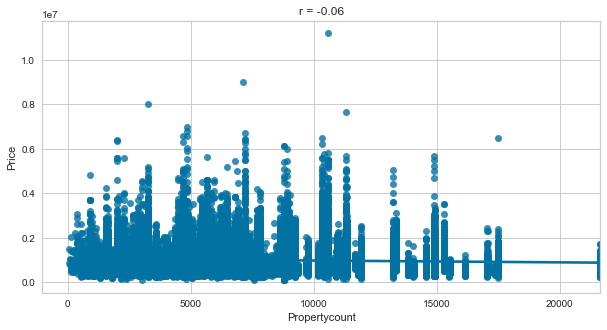

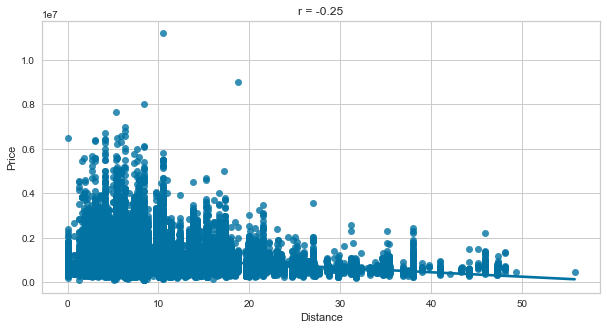

In [19]:
list_plot = ['Rooms', 'Propertycount', 'Distance']
for i in list_plot:
    plt.figure(figsize=(10,5))
    st = stats.pearsonr(data_trans[i], data_trans['Price'])     
    plt.title('r = '+ "{0:.2f}".format(st[0]))
    sns.regplot(data_trans[i], data_trans['Price'])

- Tu cac bieu do tren ta thay rang cac he so correlation deu rat thap <0.5
- Cac feature nhu propertycount co he so gan nhu bang = 0

# Relation of Categorical features to Price

In [20]:
# xem cac gia tri cua cac features
category_feature = [c for c in category_feature if c in data_trans.columns]
for catg in category_feature:
    print(data_trans[catg].value_counts())
    print('#'*50)

Reservoir           1067
Bentleigh East       696
Richmond             642
Craigieburn          598
Preston              593
Mount Waverley       556
Brunswick            540
Northcote            496
Cheltenham           493
Glen Waverley        486
Essendon             485
Glenroy              482
Coburg               464
Mill Park            454
South Yarra          436
Glen Iris            434
Pascoe Vale          433
Bundoora             431
Kew                  430
Hawthorn             429
Epping               421
St Kilda             410
Balwyn North         407
Brighton             404
Thornbury            394
Doncaster East       393
Hoppers Crossing     381
Bentleigh            378
Camberwell           376
Brighton East        366
                    ... 
Monbulk                2
Park Orchards          2
Werribee South         2
Lyndhurst              2
Ferny Creek            2
Panton Hill            2
Kallista               1
Yan Yean               1
Pentland Hills         1


Phan loai cac categorical features

- Cac feature nhu Suburb, Address, CouncilArea, Regionname,Postcode deu chi vi tri dia ly cua khu vuc cua ngoi nha.
- Vi so luong value cua cac feature Suburb, Address, CouncilArea rat nhieu nen ta se kho visualize, testing va build model
- Do do trong cac feature tren ta chon Regioname lam category dai dien de khao sat su anh huong cua khu vuc den Price

In [21]:
# Xoa cac feature 'Suburb', 'Address', 'CouncilArea','Postcode'
data_trans = data_trans.drop(['Suburb', 'Address', 'CouncilArea','Postcode'], axis=1)

In [22]:
#xu ly Date
#Phan loai du lieu Date thanh cac quy cua nam voi cac gia tri 1,2,3,4,5,6,7,8,9,10,11,12 tuong ung voi quy 1,2,3,4 cua nam 2016
# quy 1,2,3,4 cua nam 2017, quy 1,2,3,4 cua nam 2018
data_trans['Date'] = pd.to_datetime(data_trans['Date'])
data_trans['quarter'] = data_trans['Date'].dt.quarter
data_trans['year'] = data_trans['Date'].dt.year

data_trans['Quarter_of_year'] = 1
data_trans.loc[((data_trans['quarter']==2) & (data_trans['year']==2016)), 'Quarter_of_year'] = 2
data_trans.loc[((data_trans['quarter']==3) & (data_trans['year']==2016)), 'Quarter_of_year'] = 3
data_trans.loc[((data_trans['quarter']==4) & (data_trans['year']==2016)), 'Quarter_of_year'] = 4
data_trans.loc[((data_trans['quarter']==1) & (data_trans['year']==2017)), 'Quarter_of_year'] = 5
data_trans.loc[((data_trans['quarter']==2) & (data_trans['year']==2017)), 'Quarter_of_year'] = 6
data_trans.loc[((data_trans['quarter']==3) & (data_trans['year']==2017)), 'Quarter_of_year'] = 7
data_trans.loc[((data_trans['quarter']==4) & (data_trans['year']==2017)), 'Quarter_of_year'] = 8
data_trans.loc[((data_trans['quarter']==1) & (data_trans['year']==2018)), 'Quarter_of_year'] = 9
data_trans.loc[((data_trans['quarter']==2) & (data_trans['year']==2018)), 'Quarter_of_year'] = 10
data_trans.loc[((data_trans['quarter']==3) & (data_trans['year']==2018)), 'Quarter_of_year'] = 11
data_trans.loc[((data_trans['quarter']==4) & (data_trans['year']==2018)), 'Quarter_of_year'] = 12

In [23]:
# xu ly SellerG
# phan loai SellerG thanh cac nhom nguoi co so luong nha ban duoc khac nhau, voi khoang phan loai la <1000, >1000, >2000, >3000, >4000
# vi co the gia cua nguoi ban dua ra khac nhau co the anh huong so luong nha ho ban duoc (nghia la SellerG co the anh huong den Price)
SellerG_frame = data_trans['SellerG'].value_counts().to_frame()
SellerG_lower1000 = list(SellerG_frame[SellerG_frame['SellerG'] < 1000].index)
SellerG_upper1000 = list(SellerG_frame[(SellerG_frame['SellerG'] >= 1000) & (SellerG_frame['SellerG'] < 2000)].index)
SellerG_upper2000 = list(SellerG_frame[(SellerG_frame['SellerG'] >= 2000) & (SellerG_frame['SellerG'] < 3000)].index)
SellerG_upper3000 = list(SellerG_frame[(SellerG_frame['SellerG'] >= 3000) & (SellerG_frame['SellerG'] < 4000)].index)
SellerG_upper4000 = list(SellerG_frame[(SellerG_frame['SellerG'] >= 4000) & (SellerG_frame['SellerG'] < 5000)].index)

data_trans['SellerG_level'] = 1
data_trans.loc[(data_trans['SellerG'].isin(SellerG_upper1000)), 'SellerG_level'] = 2
data_trans.loc[(data_trans['SellerG'].isin(SellerG_upper2000)), 'SellerG_level'] = 3
data_trans.loc[(data_trans['SellerG'].isin(SellerG_upper3000)), 'SellerG_level'] = 4
data_trans.loc[(data_trans['SellerG'].isin(SellerG_upper4000)), 'SellerG_level'] = 5


In [24]:
# cap nhap lai cac categorical features
category_feature = ['Type', 'Method', 'Regionname', 'SellerG_level', 'Quarter_of_year']

In [25]:
data_trans.describe(percentiles=[.1,.25,.50,.75,.95,.99])

,Rooms,Price,Propertycount,Distance,quarter,year,Quarter_of_year,SellerG_level
count,48433.000000,4.843300e+04,48433.000000,48433.000000,48433.000000,48433.000000,48433.000000,48433.000000
mean,3.071666,9.978982e+05,7566.399913,12.702761,2.606611,2017.041026,6.770714,2.694568
std,0.944708,5.934989e+05,4457.405884,7.550030,1.040493,0.761373,2.968946,1.735235
min,1.000000,8.500000e+04,39.000000,0.000000,1.000000,2016.000000,1.000000,1.000000
10%,2.000000,4.800400e+05,2674.000000,4.300000,1.000000,2016.000000,2.000000,1.000000
25%,2.000000,6.200000e+05,4280.000000,7.000000,2.000000,2016.000000,4.000000,1.000000
50%,3.000000,8.300000e+05,6567.000000,11.700000,3.000000,2017.000000,7.000000,2.000000
75%,4.000000,1.220000e+06,10412.000000,16.700000,3.000000,2018.000000,9.000000,5.000000
95%,5.000000,2.100000e+06,15510.000000,26.500000,4.000000,2018.000000,11.000000,5.000000
99%,5.000000,3.200000e+06,21650.000000,38.000000,4.000000,2018.000000,12.000000,5.000000


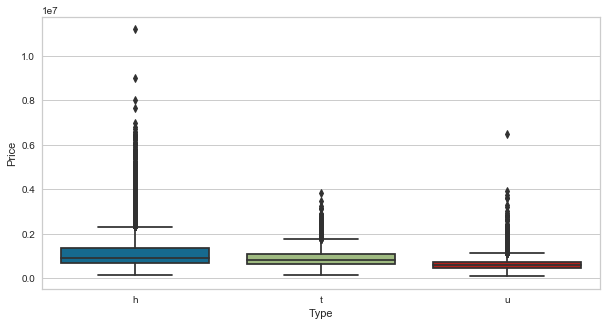

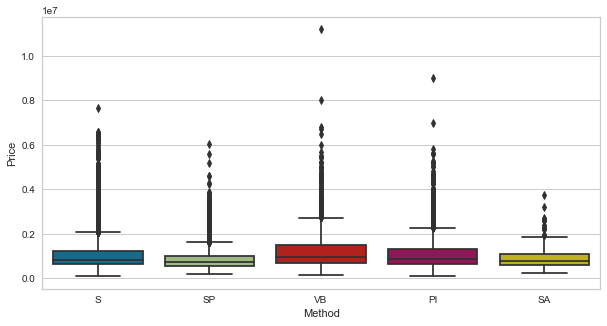

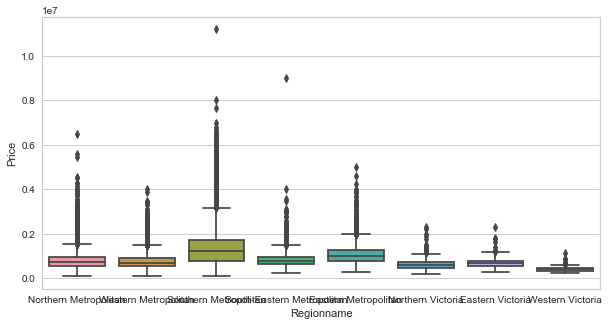

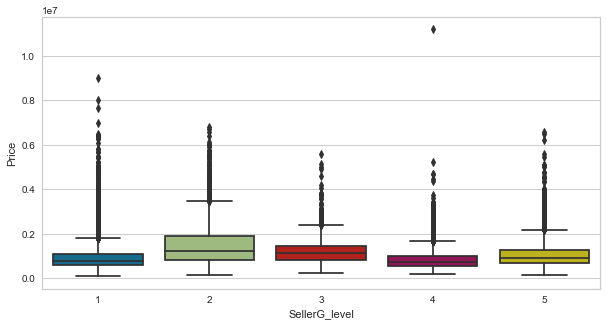

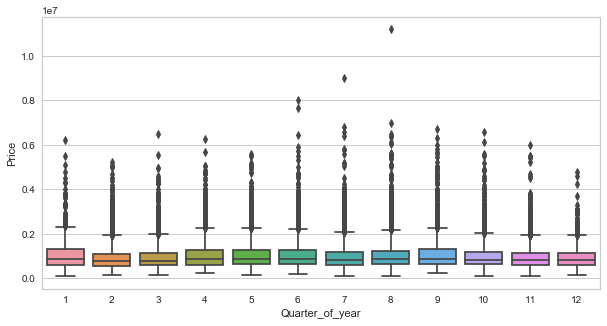

In [26]:
for i in category_feature:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=i, y='Price', data=data_trans)

Tu cac bieu do tren ta thay cac feature Type, Method, Regionname, SellerG_level, Quater_of_year deu co anh huong den Price

In [27]:
# Cap nhat lai cac feature cho tap du lieu moi de phuc vu testing va linear regression
dataset = data_trans.drop(['SellerG','quarter','year','Date'], axis=1)

# xu ly outlier

In [28]:
q1 = dataset.quantile(0.25)
q3 = dataset.quantile(0.75)
iqr = q3 - q1
dataset = dataset[~((dataset < (q1 - 1.5 * iqr)) |(dataset > (q3 + 1.5 * iqr)))]
total = dataset.isnull().sum()
percent = dataset.isnull().sum()/len(dataset)*100
missing_dataset = pd.concat([total,percent], axis=1,keys=['Total', 'Percent'])
missing_dataset

,Total,Percent
Rooms,32,0.066071
Type,0,0.000000
Price,2272,4.691016
Method,0,0.000000
Regionname,0,0.000000
Propertycount,1067,2.203043
Distance,1522,3.142485
Quarter_of_year,0,0.000000
SellerG_level,0,0.000000


In [29]:
# xoa cac missing value, luc nay du lieu con lai gan 70%
dataset = dataset.dropna()
dataset.isnull().sum()

Rooms              0
Type               0
Price              0
Method             0
Regionname         0
Propertycount      0
Distance           0
Quarter_of_year    0
SellerG_level      0
dtype: int64

In [30]:
dataset.describe(percentiles=[.1,.25,.50,.75,.95,.99])

,Rooms,Price,Propertycount,Distance,Quarter_of_year,SellerG_level
count,43559.00000,4.355900e+04,43559.000000,43559.000000,43559.000000,43559.000000
mean,3.01320,9.215156e+05,7148.287977,12.132719,6.758236,2.701967
std,0.90579,4.007110e+05,3894.292813,6.378107,2.982066,1.741218
min,1.00000,8.500000e+04,121.000000,0.000000,1.000000,1.000000
10%,2.00000,4.825000e+05,2651.000000,4.300000,2.000000,1.000000
25%,2.00000,6.200000e+05,4181.000000,6.800000,4.000000,1.000000
50%,3.00000,8.250000e+05,6388.000000,11.400000,7.000000,2.000000
75%,4.00000,1.175000e+06,9758.000000,16.700000,9.000000,5.000000
95%,4.00000,1.735000e+06,14949.000000,23.200000,11.000000,5.000000
99%,5.00000,2.000000e+06,16166.000000,27.200000,12.000000,5.000000


# Heatmap

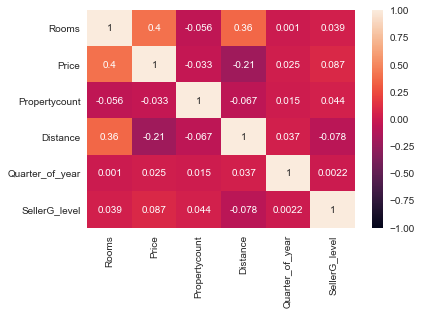

In [31]:
sns.heatmap(dataset.corr(), vmax=1.0, vmin=-1.0, annot=True)

Tu bieu do tren ta thay giua Price va Rooms co he so tuong quan cao nhat (0.4), con cac feature con lai co he so tuong quan tuong doi thap

# 1.2. Testing

In [32]:
dataset.columns

Index(['Rooms', 'Type', 'Price', 'Method', 'Regionname', 'Propertycount',
       'Distance', 'Quarter_of_year', 'SellerG_level'],
      dtype='object')

In [33]:
percent_sample = 0.5
#testing Rooms
f, p = f_oneway(dataset[dataset['Rooms']==1]['Price'].sample(frac=percent_sample),
                dataset[dataset['Rooms']==2]['Price'].sample(frac=percent_sample),
                dataset[dataset['Rooms']==3]['Price'].sample(frac=percent_sample),
                dataset[dataset['Rooms']==4]['Price'].sample(frac=percent_sample),
                dataset[dataset['Rooms']==5]['Price'].sample(frac=percent_sample),
                dataset[dataset['Rooms']==6]['Price'].sample(frac=percent_sample),
                dataset[dataset['Rooms']>=7]['Price'].sample(frac=percent_sample))
if p < 0.05:
    print('Reject H0, Rooms la Key factor cua Price')
else:
    print('Accept H0, Rooms khong phai la Key factor cua Price')

Reject H0, Rooms la Key factor cua Price


In [34]:
#testing Type
f, p = f_oneway(dataset[dataset['Type']=='h']['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Type']=='u']['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Type']=='t']['Price'].sample(frac=percent_sample))
if p < 0.05:
    print('Reject H0, Type la Key factor cua Price')
else:
    print('Accept H0, Type khong phai la Key factor cua Price')

Reject H0, Type la Key factor cua Price


In [35]:
# dataset['Method'].value_counts()
#test Method
f, p = f_oneway(dataset[dataset['Method']=='S']['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Method']=='PI']['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Method']=='SP']['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Method']=='VB']['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Method']=='SA']['Price'].sample(frac=percent_sample))
if p < 0.05:
    print('Reject H0, Method la Key factor cua Price')
else:
    print('Accept H0, Method khong phai la Key factor cua Price')

Reject H0, Method la Key factor cua Price


In [36]:
# dataset['Regionname'].value_counts()
#testing Regionname
f, p = f_oneway(dataset[dataset['Regionname']=='Northern Metropolitan']['Price'].sample(frac=percent_sample),
                dataset[dataset['Regionname']=='Southern Metropolitan']['Price'].sample(frac=percent_sample),
                dataset[dataset['Regionname']=='Western Metropolitan']['Price'].sample(frac=percent_sample),
                dataset[dataset['Regionname']=='Eastern Metropolitan']['Price'].sample(frac=percent_sample),
                dataset[dataset['Regionname']=='South-Eastern Metropolitan']['Price'].sample(frac=percent_sample),
                dataset[dataset['Regionname']=='Eastern Victoria']['Price'].sample(frac=percent_sample),
                dataset[dataset['Regionname']=='Northern Victoria']['Price'].sample(frac=percent_sample),
                dataset[dataset['Regionname']=='Western Victoria']['Price'].sample(frac=percent_sample))
if p < 0.05:
    print('Reject H0, Regionname la Key factor cua Price')
else:
    print('Accept H0, Regionname khong phai la Key factor cua Price')

Reject H0, Regionname la Key factor cua Price


In [37]:
# testing Propertycount
Propertycount_upper0 = dataset[(dataset['Propertycount']>=0) & (dataset['Propertycount']<5000)]
Propertycount_upper5 = dataset[(dataset['Propertycount']>=5000) & (dataset['Propertycount']<10000)].sample(frac=percent_sample)
Propertycount_upper10 = dataset[(dataset['Propertycount']>=10000) & (dataset['Propertycount']<15000)].sample(frac=percent_sample)
Propertycount_upper15 = dataset[(dataset['Propertycount']>=15000)].sample(frac=percent_sample)
# Propertycount_upper20 = dataset[dataset['Propertycount']>=20000].sample(frac=percent_sample)
f, p = f_oneway(Propertycount_upper0['Price'].sample(frac=percent_sample),
                Propertycount_upper5['Price'].sample(frac=percent_sample),
                Propertycount_upper10['Price'].sample(frac=percent_sample),
                Propertycount_upper15['Price'].sample(frac=percent_sample))
#                 Propertycount_upper20['Price'].sample(frac=percent_sample))
if p < 0.05:
    print('Reject H0, Propertycount la Key factor cua Price')
else:
    print('Accept H0, Propertycount khong phai la Key factor cua Price')

Reject H0, Propertycount la Key factor cua Price


In [38]:
#testing Distance
Distance_upper0 = dataset[(dataset['Distance']>=0) & (dataset['Distance']<10)]
Distance_upper10 = dataset[(dataset['Distance']>=10) & (dataset['Distance']<20)].sample(frac=percent_sample)
Distance_upper20 = dataset[(dataset['Distance']>=20) & (dataset['Distance']<30)].sample(frac=percent_sample)
Distance_upper30 = dataset[(dataset['Distance']>=30)].sample(frac=percent_sample)
f, p = f_oneway(Distance_upper0['Price'].sample(frac=percent_sample),
                Distance_upper10['Price'].sample(frac=percent_sample),
                Distance_upper20['Price'].sample(frac=percent_sample),
                Distance_upper30['Price'].sample(frac=percent_sample))
if p < 0.05:
    print('Reject H0, Distance la Key factor cua Price')
else:
    print('Accept H0, Distance khong phai la Key factor cua Price')

Reject H0, Distance la Key factor cua Price


In [39]:
#test Quarter_of_year
f, p = f_oneway(dataset[dataset['Quarter_of_year']==1]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Quarter_of_year']==2]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Quarter_of_year']==3]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Quarter_of_year']==4]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Quarter_of_year']==5]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Quarter_of_year']==6]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Quarter_of_year']==7]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Quarter_of_year']==8]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Quarter_of_year']==9]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Quarter_of_year']==10]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Quarter_of_year']==11]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['Quarter_of_year']==12]['Price'].sample(frac=percent_sample))
if p < 0.05:
    print('Reject H0, Quarter_of_year la Key factor cua Price')
else:
    print('Accept H0, Quarter_of_year khong phai la Key factor cua Price')

Reject H0, Quarter_of_year la Key factor cua Price


In [40]:
#testing SellerG_level
f, p = f_oneway(dataset[dataset['SellerG_level']==1]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['SellerG_level']==2]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['SellerG_level']==3]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['SellerG_level']==4]['Price'].sample(frac=percent_sample)
                ,dataset[dataset['SellerG_level']==5]['Price'].sample(frac=percent_sample))
if p < 0.05:
    print('Reject H0, SellerG_level la Key factor cua Price')
else:
    print('Accept H0, SellerG_level khong phai la Key factor cua Price')

Reject H0, SellerG_level la Key factor cua Price


Sau khi thuc hien testing thi tat ca cac feature 'Rooms', 'Type', 'Price', 'Method', 'Regionname', 'Propertycount', 'Distance', 'Quarter_of_year', 'SellerG_level' co anh huong den Price

# 2. Apply the model for prediction with holdout and cross validation

# 2.1 Holdout

In [41]:
dataset.columns

Index(['Rooms', 'Type', 'Price', 'Method', 'Regionname', 'Propertycount',
       'Distance', 'Quarter_of_year', 'SellerG_level'],
      dtype='object')

In [42]:
# encoding cho cac categorical features
data_enc = pd.get_dummies(dataset, columns = ['Type','Method','Regionname','Quarter_of_year','SellerG_level'])
data_enc.shape

(43559, 37)

In [43]:
# Split
# Create features variable 
X = data_enc.drop('Price',axis = 1)
# Create target variable
y = data_enc['Price']

# # Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .20, random_state= 0)

In [44]:
# Create linear regression object
regressor = LinearRegression()

# Fit model to training data
regressor.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
# Predict
# Predicting test set results
y_pred = regressor.predict(X_test)

In [46]:
# Score It
print('MSE:',metrics.mean_squared_error(y_test,y_pred))

MSE: 64144626422.40727


In [47]:
print('R^2 =',metrics.explained_variance_score(y_test,y_pred))

R^2 = 0.5903437405820755


# 2.2 Cross validation

In [48]:
cv_results = cross_validate(regressor, X, y, cv=5)
cv_results['test_score']

array([0.56765747, 0.59188998, 0.58935624, 0.59685375, 0.59493109])

# 3. Using PCA, apply the model with holdout and cross validation

- Step 1. Data Standardization
- Step 2: Covariance Matrix
- Step 3: Eigen Decomposition of Covariance Matrix
- Step 4: Projection Onto New Feature Space

Step 1. Data Standardization
- As PCA deals with variance maximization of two variables, it is important to have both variables on same scale.

In [49]:
Xstd = StandardScaler().fit_transform(X)

Step 2: Covariance Matrix

In [50]:
print('Covariance matrix: \n', np.cov(Xstd.T))

Covariance matrix: 
 [[ 1.00002296 -0.0564702   0.36330029 ...  0.01820343  0.01616335
   0.02939047]
 [-0.0564702   1.00002296 -0.06718251 ... -0.05532429  0.09966988
  -0.00538644]
 [ 0.36330029 -0.06718251  1.00002296 ...  0.09728113  0.12245904
  -0.15594452]
 ...
 [ 0.01820343 -0.05532429  0.09728113 ...  1.00002296 -0.10050582
  -0.14787674]
 [ 0.01616335  0.09966988  0.12245904 ... -0.10050582  1.00002296
  -0.25133014]
 [ 0.02939047 -0.00538644 -0.15594452 ... -0.14787674 -0.25133014
   1.00002296]]


Step 3: Eigen Decomposition of Covariance Matrix

In [51]:
cov_mat = np.cov(Xstd.T)
eigen_values, eigen_vectors = np.linalg.eig(cov_mat)
# print('Eigen vectors \n',eigen_vectors)
# print('\nEigen values \n',eigen_values)

Now, Making list of eigen values and vectors and sorting the list w.r.t eigen values (Descending order) where highest eigen values represent highest variation.

In [52]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs.sort()
pairs.reverse()

# print('Eigen Values in descending order:')
# for i in pairs:
#     print(i[0])

To check how much each Principle component represent variation, let us find the cumulative sum of eigen values and plot them.

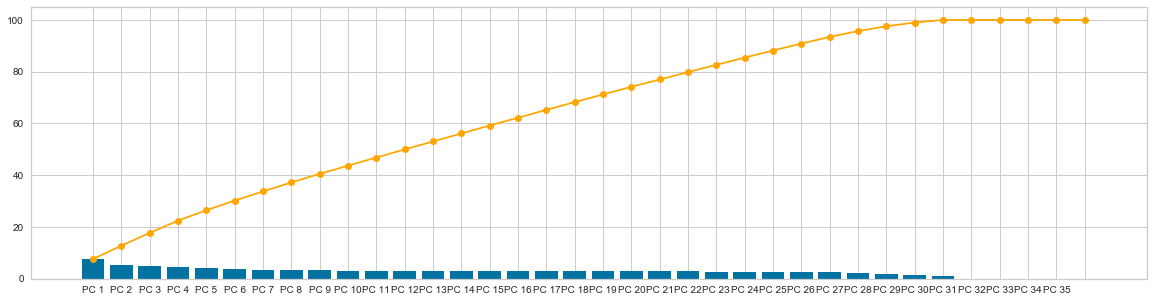

In [53]:
tot = sum(eigen_values)
var_per = [(i / tot)*100 for i in sorted(eigen_values, reverse=True)]
cum_var_per = np.cumsum(var_per)

plt.figure(figsize=(20,5))
x=['PC %s' %i for i in range(1,len(var_per))]
ind = np.arange(len(var_per)) 
plt.bar(ind,var_per)
plt.xticks(ind,x);
plt.plot(ind,cum_var_per,marker="o",color='orange')
plt.xticks(ind,x);

The graph shows that first 31 components carry 100% information.

Step 4: Projection Onto New Feature Space

Reshaping eigen pairs to form a projection matrix, which is then multiplied by samples to transform data to new feature space

In [54]:
N=36
value=31
a = np.ndarray(shape = (N, 0))
for x in range(0,value):
    b = pairs[x][1].reshape(N,1)
    a = np.hstack((a,b))
# print("Projection Matrix:\n",a)

In [55]:
# Y = Xstd.dot(a)
# Y

In [56]:
sklearn_pca = PCA(n_components=value)
reduced_data = sklearn_pca.fit_transform(Xstd)

In [57]:
# print(reduced_data)

# 3.1 Holdout

In [58]:
# # Train, test, split
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(reduced_data,y, test_size = .20, random_state= 0)

In [59]:
# Create linear regression object
regressor_pca = LinearRegression()

# Fit model to training data
regressor_pca.fit(X_pca_train,y_pca_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [60]:
# Predict
# Predicting test set results
y_pca_pred = regressor_pca.predict(X_pca_test)

In [61]:
# Score It
print('MSE:',metrics.mean_squared_error(y_pca_test,y_pca_pred))

MSE: 64144626422.40722


In [62]:
print('R^2 =',metrics.explained_variance_score(y_pca_test,y_pca_pred))

R^2 = 0.5903437405820757


# 3.2 Cross validation

In [63]:
cv_results = cross_validate(regressor, reduced_data, y, cv=5)
cv_results['test_score']

array([0.56765747, 0.59188998, 0.58935624, 0.59685375, 0.59493109])

# 4. Visualize the residue

# 4.1 No PCA

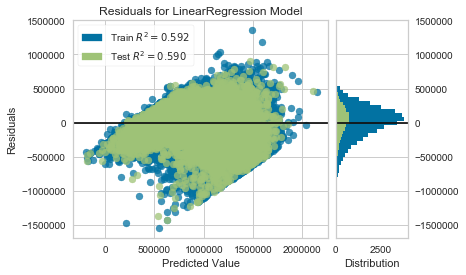

In [64]:
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

# 4.2 PCA

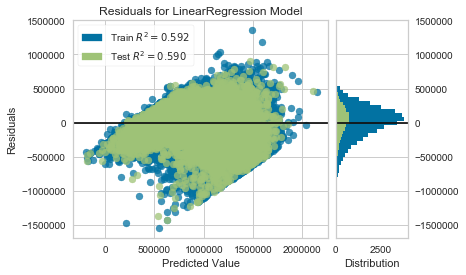

In [65]:
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_pca_train, y_pca_train)  # Fit the training data to the visualizer
visualizer.score(X_pca_test, y_pca_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

# 5. Tune the model if necessary

# 5.1 No PCA

In [66]:
params = {'copy_X':(True, False),'fit_intercept': (True, False), 'normalize': (True, False)}
model = LinearRegression()
tune = GridSearchCV(estimator=model, param_grid=params,)
tune.fit(X_train, y_train)

best_params = tune.best_params_
score = tune.best_score_
print('Config params: ', best_params)
print('Score: %2.4f' % score)

C:\Users\Os\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Config params:  {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Score: 0.5906


# 5.2 PCA

In [67]:
params = {'copy_X':(True, False),'fit_intercept': (True, False), 'normalize': (True, False)}
model = LinearRegression()
tune = GridSearchCV(estimator=model, param_grid=params)
tune.fit(X_pca_train, y_pca_train)
best_params = tune.best_params_
score = tune.best_score_
print('Config params : ', best_params)
print('Score: %2.4f' % score)

C:\Users\Os\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Config params :  {'copy_X': True, 'fit_intercept': True, 'normalize': True}
Score: 0.5906


# Conclusion

- Dữ liệu có nhiều missing ở cột Price (>20%)
- Các feature Rooms, Distance, Propertycount, Price có một số giá trị outlier (<5%)
- Thông qua testing (anova) nhận thấy các features: Rooms, Distance, Date, Propertycount, Seller_G, Type, Method, Regionname deu co anh huong den Price
- Model có score khoang 0.6, tức độ chính xác dự đoán khoảng 60%
- Model không sử dụng PCA và có sử dụng PCA có độ chính xác dự đoán gần như nhau khoảng gần 60%
- Tune model không có thay đổi gì nhiều so với mặc định trước đó